In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Add
from tensorflow.keras.layers import Activation, Flatten, Dense, AveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import os
from PIL import Image
from tensorflow.keras.models import Model

2023-06-07 09:32:47.666883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# After downloading Air-Pollution-Image-Dataset-From-India-and-Nepal dataset from kaggle, extract it and pass the path for all the respective csv file for training, validation and test.

In [ ]:
# Specify the file paths for the training, validation, and testing CSV files
train_csv_file = 'Datasets/train_data.csv'
val_csv_file = 'Datasets/val_data.csv'
test_csv_file = 'Datasets/testing_data.csv'

In [ ]:
# Read the training CSV file into a DataFrame
train_df = pd.read_csv(train_csv_file)

# Read the validation CSV file into a DataFrame
val_df = pd.read_csv(val_csv_file)

# Read the testing CSV file into a DataFrame
test_df = pd.read_csv(test_csv_file)

def compute_dataset_stats(data_dir, target_size=(224, 224)):
    images = []
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(root, file)
                img = Image.open(img_path).resize(target_size)
                img = np.array(img) / 255.0  # 將像素值縮放到 [0, 1]
                images.append(img)

    images = np.array(images)
    mean = np.mean(images, axis=(0, 1, 2))  # 對每個通道計算均值
    std = np.std(images, axis=(0, 1, 2))    # 對每個通道計算標準差
    return mean, std

path = 'Datasets/Images'
mean, std = compute_dataset_stats(path)

def custom_standardization(image, mean=mean, std=std):
    return (image - mean) / std

# Create ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    preprocessing_function=lambda x: custom_standardization(x, mean, std)
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: custom_standardization(x, mean, std)
)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical'
)

Found 7833 validated image filenames belonging to 6 classes.
Found 1959 validated image filenames belonging to 6 classes.
Found 2448 validated image filenames belonging to 6 classes.


# write your code here to create and train your model for image classificatoin for AQI class

In [ ]:
# Using ResNet50 as the base model

def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True, weight_decay=1e-4):
    shortcut = x
    
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride, padding='valid', kernel_regularizer=l2(weight_decay))(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # 第一層卷積
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 第二層卷積
    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    
    # 捷徑連繫
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

# 搭建 ResNet50 模型
def build_resnet50(input_shape=(224, 224, 3), num_classes=6, weight_decay=1e-4):
    inputs = Input(shape=input_shape)
    
    # 初始卷積層
    x = Conv2D(64, 7, strides=2, padding='same', kernel_regularizer=l2(weight_decay))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Conv2_x
    x = residual_block(x, 64, conv_shortcut=True, weight_decay=weight_decay)
    x = residual_block(x, 64, conv_shortcut=False, weight_decay=weight_decay)
    x = residual_block(x, 64, conv_shortcut=False, weight_decay=weight_decay)
    
    # Conv3_x
    x = residual_block(x, 128, stride=2, conv_shortcut=True, weight_decay=weight_decay)
    x = residual_block(x, 128, conv_shortcut=False, weight_decay=weight_decay)
    x = residual_block(x, 128, conv_shortcut=False, weight_decay=weight_decay)
    x = residual_block(x, 128, conv_shortcut=False, weight_decay=weight_decay)
    
    # Conv4_x
    x = residual_block(x, 256, stride=2, conv_shortcut=True, weight_decay=weight_decay)
    x = residual_block(x, 256, conv_shortcut=False, weight_decay=weight_decay)
    x = residual_block(x, 256, conv_shortcut=False, weight_decay=weight_decay)
    x = residual_block(x, 256, conv_shortcut=False, weight_decay=weight_decay)
    x = residual_block(x, 256, conv_shortcut=False, weight_decay=weight_decay)
    x = residual_block(x, 256, conv_shortcut=False, weight_decay=weight_decay)
    
    # Conv5_x
    x = residual_block(x, 512, stride=2, conv_shortcut=True, weight_decay=weight_decay)
    x = residual_block(x, 512, conv_shortcut=False, weight_decay=weight_decay)
    x = residual_block(x, 512, conv_shortcut=False, weight_decay=weight_decay)
    
    # 全局平均池化與全連繫層
    x = AveragePooling2D(7)(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax', kernel_regularizer=l2(weight_decay))(x)
    
    model = Model(inputs, x)
    return model

# 計算資料集均值與標準差
def compute_dataset_stats(data_dir, target_size=(224, 224)):
    images = []
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(root, file)
                img = Image.open(img_path).resize(target_size)
                img = np.array(img) / 255.0
                images.append(img)
    
    images = np.array(images)
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))
    return mean, std

# 自訂標準化函數
def custom_standardization(image, mean, std):
    return (image - mean) / std

model = build_resnet50(input_shape=(224, 224, 3), num_classes=6)

In [ ]:
#compile your model here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#train you model here

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # 連續 5 個 epoch 無改善則停止
    restore_best_weights=True,  # 恢復最佳權重
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=100,
    callbacks=[early_stopping],
)

model.save('resnet50_aqi_model.h5')

# plot your Training Accuracy and validation accuracy here

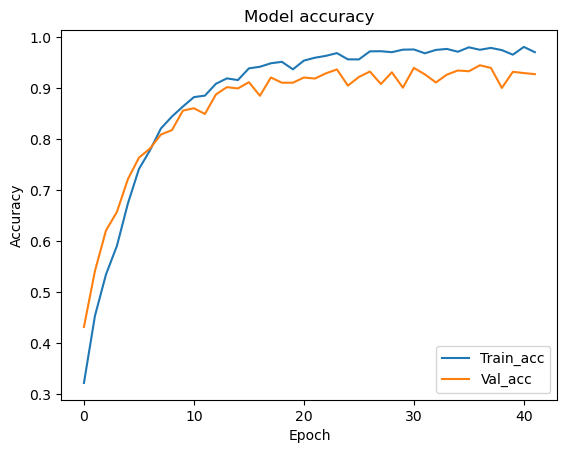

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')

plt.ylabel('Accuracy')
plt.legend(['Train_acc', 'Val_acc'], loc='lower right')
plt.show()

# Test your test data and save your result file in this format and upload your solution file on kaggle competition

In [ ]:
test_probabilities = model.predict(test_generator)
test_filenames = test_generator.filenames
test_probabilities_df = pd.DataFrame(test_probabilities, columns=['a_Good', 'b_Moderate', 
                                                                  'c_Unhealthy_for_Sensitive_Groups', 'd_Unhealthy', 
                                                                  'e_Very_Unhealthy', 'f_Severe'])
test_probabilities_df.insert(0, 'Filename', test_filenames)
test_probabilities_df.to_csv('/Outputs/test_results.csv', index=False)


77/77 [==============================] - 7s 88ms/step


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

# Generate predictions for the test data
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Get the true labels and predicted probabilities
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)

# Calculate the F1 score for each class
f1_scores = f1_score(y_true, y_pred, average=None)


In [ ]:
# Calculate the F1 score for each class
f1_scores = f1_score(y_true, y_pred, average=None)

# Calculate the average F1 score
average_f1_score = f1_score(y_true, y_pred, average='macro')

# Print the F1 scores for each class
for i, f1 in enumerate(f1_scores):
    print("Class {}: F1 Score = {:.4f}".format(i, f1))

# Print the average F1 score
print("Average F1 Score: {:.4f}".format(average_f1_score))
print()
print("Test Accuracy: {:.4f}".format(test_accuracy))

Class 0: F1 Score = 0.1291
Class 1: F1 Score = 0.1246
Class 2: F1 Score = 0.2170
Class 3: F1 Score = 0.2386
Class 4: F1 Score = 0.1808
Class 5: F1 Score = 0.1456
Average F1 Score: 0.1726

Test Accuracy: 0.9502


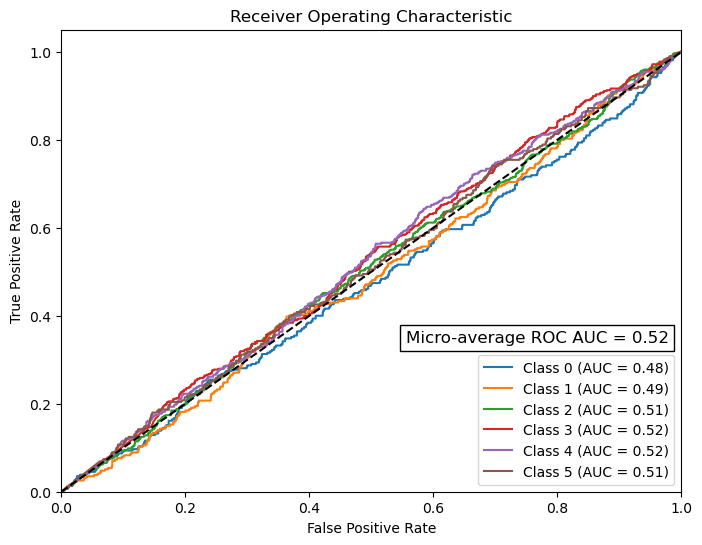

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=list(range(len(test_generator.class_indices))))

# Calculate the ROC AUC score for each class
roc_auc_scores = roc_auc_score(y_true_binarized, y_pred_prob, average='micro')

# Plot the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test_generator.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_true_binarized[:, i], y_pred_prob[:, i])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(test_generator.class_indices)):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot the random chance curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Add micro-average ROC AUC score to the plot
plt.text(0.555, 0.34, 'Micro-average ROC AUC = %0.2f' % roc_auc_scores, fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix

# Generate predictions for the training data
train_pred = model.predict(train_generator)
train_pred = np.argmax(train_pred, axis=1)  # Convert predictions to class labels

# Generate predictions for the validation data
val_pred = model.predict(val_generator)
val_pred = np.argmax(val_pred, axis=1)  # Convert predictions to class labels

# Generate predictions for the testing data
test_pred = model.predict(test_generator)
test_pred = np.argmax(test_pred, axis=1)  # Convert predictions to class labels

# Calculate overall MAE and RMSE
train_mae = mean_absolute_error(train_generator.classes, train_pred)
train_rmse = np.sqrt(mean_squared_error(train_generator.classes, train_pred))

val_mae = mean_absolute_error(val_generator.classes, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_generator.classes, val_pred))

test_mae = mean_absolute_error(test_generator.classes, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_generator.classes, test_pred))

print("Overall MAE - Training: {:.4f}".format(train_mae))
print("Overall RMSE - Training: {:.4f}".format(train_rmse))
print("Overall MAE - Validation: {:.4f}".format(val_mae))
print("Overall RMSE - Validation: {:.4f}".format(val_rmse))
print("Overall MAE - Testing: {:.4f}".format(test_mae))
print("Overall RMSE - Testing: {:.4f}".format(test_rmse))

77/77 [==============================] - 7s 90ms/step
Overall MAE - Training: 1.7290
Overall RMSE - Training: 2.1572
Overall MAE - Validation: 1.7228
Overall RMSE - Validation: 2.1775
Overall MAE - Testing: 1.7083
Overall RMSE - Testing: 2.1430


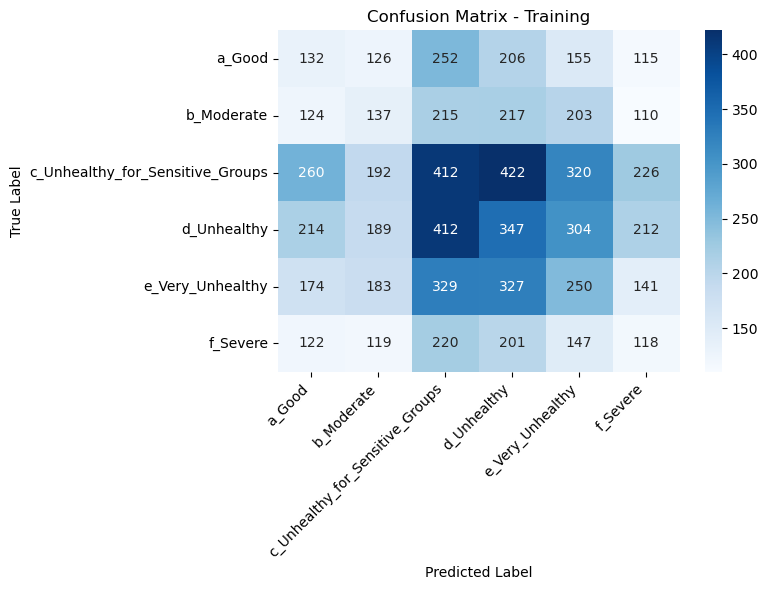

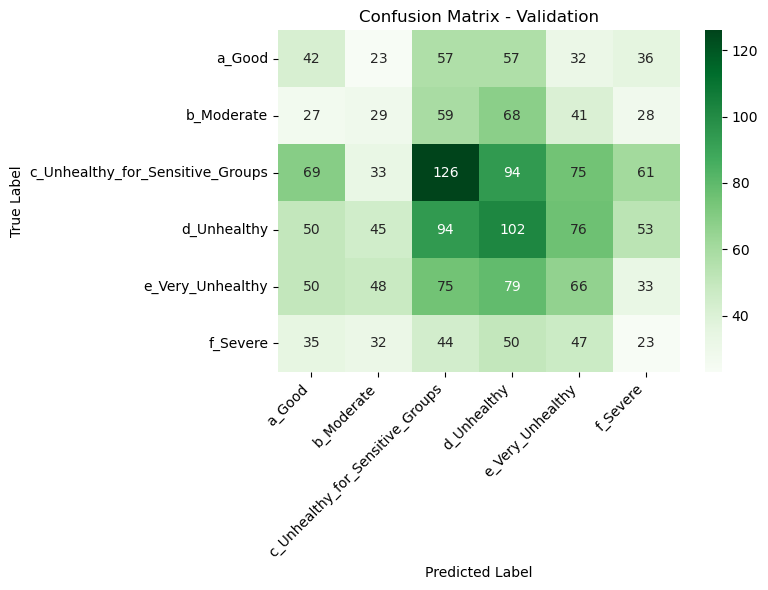

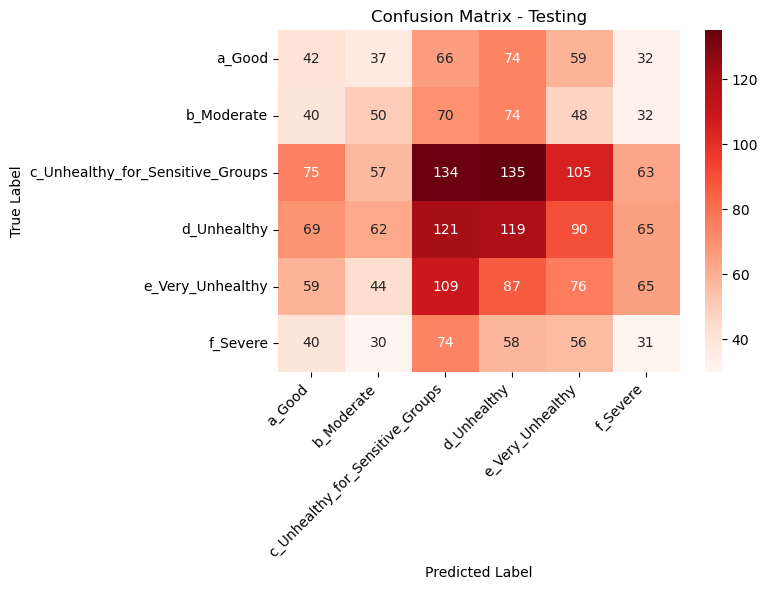

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrices
train_cm = confusion_matrix(train_generator.classes, train_pred)
val_cm = confusion_matrix(val_generator.classes, val_pred)
test_cm = confusion_matrix(test_generator.classes, test_pred)

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Training')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, cmap='Greens', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Validation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Testing')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
